# AABC cumulative recruitment stats and visuals


In [320]:
# check out  ~/cron/aabc_recruits.sh
#

In [321]:
#load some libraries
import pandas as pd
import seaborn as sns
from ccf.box import LifespanBox
import yaml
from functions import *
from config import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import warnings
from itables import show
import itables.options as opt
warnings.filterwarnings('ignore')

In [322]:
opt.maxBytes = "128KB"

In [323]:
print(date.today().strftime("%m/%d/%Y"))

10/23/2024


In [324]:
#load HCA inventory 
config = LoadSettings()
secret=pd.read_csv(config['config_files']['secrets'])
box = LifespanBox(cache="./tmp")
pathp=box.downloadFile(config['hcainventory'])
ids=pd.read_csv(pathp)

In [325]:
## get configuration files
intradb=pd.read_csv(config['config_files']['PCP'])
aabc_processing=config['aabc_processing']

In [326]:
DNR = ["HCA7787304_V1", "HCA6276071_V1", "HCA6229365_V1", "HCA9191078_V1", "HCA6863086_V1"]
#These guys accidentally recruited as V2
v2oops=['HCA6686191','HCA7296183']

In [327]:
aabcdictionary='AABC_REDCap_DataDictionary_2023-05-15.csv'                 # aabc REDCap data dictionary...necessary for automating variables at appropriate events - put in tmpdir
#AABCdict=pd.read_csv(outp+aabcdictionary,low_memory=False)
E=pd.read_csv(box.downloadFile(config['encyclopedia']),low_memory=False,encoding='ISO-8859-1')
SSAGAvars=list(E.loc[E['Form / Instrument'].str.upper().str.contains('SSAGA'),'Variable / Field Name'])

In [328]:
hcaids=ids.subject.drop_duplicates()
#for later use in getting the last visit for each participant in HCA so that you can later make sure that person is starting subsequent visit and not accidentally enrolled in the wrong arm
hca_lastvisits=ids[['subject','redcap_event']].loc[ids.redcap_event.isin(['V1','V2'])].sort_values('redcap_event').drop_duplicates(subset='subject',keep='last')

In [329]:
#load AABC report
aabcarms = redjson(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0])
hcpa = redjson(tok=secret.loc[secret.source=='hcpa','api_key'].reset_index().drop(columns='index').api_key[0])
#just a report
aabcreport = redreport(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0],reportid='51031')


In [330]:

#download the inventory report from AABC for comparison
aabcinvent=getframe(struct=aabcreport,api_url=config['Redcap']['api_url10'])


HTTP Status: 200


## CODE RED!

In [331]:
#find subjectts who have completed a visit and are not DNR - save for later
reds=aabcinvent.loc[aabcinvent.register_visit_complete =='2'][['study_id']]
inperson=list(reds.study_id.unique())
reds2=aabcinvent.loc[(aabcinvent.study_id.isin(inperson)) & (~(aabcinvent.subject_id =='')) & (~(aabcinvent.subject_id.isin(DNR)))]
inpersonHCAid=list(reds2.subject_id.unique())

In [332]:
#trying to set study_id from config file, but have been sloppy...there are instances where the actual subject_id has been coded below
study_id=config['Redcap']['datasources']['aabcarms']['redcapidvar']

#slim selects just the registration event (V0) because thats where the ids and legacy information is kept.
slim=aabcinvent[['study_id','redcap_event_name',study_id,'legacy_yn','site','v0_date']].loc[(aabcinvent.redcap_event_name.str.contains('register'))]

#compare aabc ids against hcaids and whether legacy information is properly accounted for (e.g. legacy variable flags and actual event in which participannt has been enrolled.
fortest=pd.merge(hcaids,slim,left_on='subject',right_on=study_id,how="outer",indicator=True)
#fortest._merge.value_counts()
legacyarms=['register_arm_1','register_arm_2','register_arm_3','register_arm_4','register_arm_5','register_arm_6','register_arm_7','register_arm_8']

In [333]:
# First batch of flags: Look for legacy IDs that don't actually exist in HCA
ft=fortest.loc[(fortest._merge=='right_only') & ((fortest.legacy_yn=='1')|(fortest.redcap_event_name.isin(legacyarms)))]
#remove the TEST subjects -- probably better to do this first, but sigh.
ft=ft.loc[~((ft[study_id]=='')|(ft[study_id].str.upper().str.contains('TEST')))]
qlist1=pd.DataFrame()
if not ft.empty:
    ft['reason']='Subject found in AABC REDCap Database with legacy indications whose ID was not found in HCP-A list'
    ft['issueCode']='AE1001'
    ft['datatype']='REDCap'
    ft['code']='RED'
    qlist1=ft[['subject_id', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','datatype']]
    for s in list(ft[study_id].unique()):
        print('CODE RED :',s,': Subject found in AABC REDCap Database with legacy indications whose ID was not found in HCP-A list')

#2nd batch of flags: if legacy v1 and enrolled as if v3 or v4 or legacy v2 and enrolled v4
ft2=fortest.loc[(fortest._merge=='both') & ((fortest.legacy_yn != '1')|(~(fortest.redcap_event_name.isin(legacyarms))))]
qlist2=pd.DataFrame()
if not ft2.empty:
    ft2['reason']='Subject found in AABC REDCap Database with legacy indications whose ID was not found in HCP-A list'
    ft2['code']='RED'
    ft2['issueCode'] = 'AE1001'
    ft2['datatype']='REDCap'
    qlist2 = ft2[['subject_id', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','datatype']]
    for s2 in list(ft2[study_id].unique()):
        print('CODE RED :',s2,': Subject found in AABC REDCap Database with an ID from HCP-A study but no legacyYN not checked')



CODE RED : delete (HCA9198092 refusal) : Subject found in AABC REDCap Database with legacy indications whose ID was not found in HCP-A list


In [334]:
# Check if subject fail the screen but came in for visit
pass_failed=aabcinvent.loc[(aabcinvent.passedscreen =='2') & (aabcinvent['subject_id'].astype(str).str.strip() != '')][['subject_id', 'study_id', 'redcap_event_name', 'site','v0_date']]
qlist4=pd.DataFrame()
if not pass_failed.empty:
    pass_failed['reason']='subject did not pass screen but came in for imaging - need confirmation'
    pass_failed['code']='RED'
    pass_failed['issueCode'] = 'AE1001'
    pass_failed['datatype']='REDCap'
    qlist4 = pass_failed[['subject_id', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','datatype']]
    for s4 in list(pass_failed[study_id].unique()):
        print('CODE RED :',s4,': subject did not pass screen but came in for imaging - need confirmation')

In [335]:
#if legacy v1 and enrolled as if v3 or v4 or legacy v2 and enrolled v4
#get last visit
hca_lastvisits["next_visit"]=''
#idvisits rolls out the subject ids to all visits. get subects current visit for comparison with last visit
aabcidvisits=idvisits(aabcinvent,keepsies=['study_id','redcap_event_name','site','subject_id','v0_date','event_date'])
sortaabc=aabcidvisits.sort_values(['study_id','redcap_event_name'])
sortaabcv=sortaabc.loc[~(sortaabc.redcap_event_name.str.contains('register'))]
sortaabcv.drop_duplicates(subset=['study_id'],keep='first')
#print("OOOPSs:",sortaabcv.loc[sortaabcv.subject.isin(v2oops)])
#add 1 to last visit from HCA
#also set up for checking to make sure not initiating same visit
hca_lastvisits.next_visit=hca_lastvisits.redcap_event.str.replace('V','').astype('int') +1
hca_lastvisits["next_visit2"]="V"+hca_lastvisits.next_visit.astype(str)
hca_lastvisits2=hca_lastvisits.drop(columns=['redcap_event','next_visit'])

In [336]:
#check that current visit in AABC is the last visit in HCA + 1
check=pd.merge(hca_lastvisits2,sortaabcv,left_on=['subject','next_visit2'],right_on=['subject','redcap_event'],how='outer',indicator=True)
check=check.loc[check._merge !='left_only']
wrongvisit=check.loc[check._merge=='right_only']
wrongvisit=wrongvisit.loc[~(wrongvisit.redcap_event.isin(['AP']))]#,'v1_inperson_arm_10','v1_inperson_arm_12']))]
wrongvisit=wrongvisit.loc[wrongvisit.next_visit2.isnull()==False]

In [337]:
qlist3=pd.DataFrame()
if not wrongvisit.empty:
    wrongvisit['reason']='Subject found in AABC REDCap Database initiating the wrong visit sequence (e.g. V3 insteady of V2'
    wrongvisit['code']='RED'
    wrongvisit['issueCode'] = 'AE1001'
    wrongvisit['datatype']='REDCap'
    qlist3 = wrongvisit[['subject', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','event_date','datatype']]
    qlist3=qlist3.rename(columns={'subject':'subject_id'})
    for s3 in list(wrongvisit['subject'].unique()):
        if s3 !='':
            print('CODE RED (if HCA6911778 ignore) :',s3,': Subject found in AABC REDCap Database initiating the wrong visit sequence (e.g. V3 insteady of V2')
            qlist3=qlist3.loc[~(qlist3.subject_id=='HCA6911778')].copy()

In [338]:
#check to make sure they aren't initiating the same visit.
check2=pd.merge(hca_lastvisits[['subject','redcap_event']],sortaabcv,left_on=['subject','redcap_event'],right_on=['subject','redcap_event'],how='inner')
check2=check2.loc[~(check2.subject.isin(v2oops))]
qlist32=pd.DataFrame()
if not check2.empty:
    check2['reason']='Subject found in AABC REDCap Database initiating the wrong visit sequence (e.g. V3 insteady of V2'
    check2['code']='RED'
    check2['issueCode'] = 'AE1001'
    check2['datatype']='REDCap'
    qlist32 = check2[['subject', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','event_date','datatype']]
    qlist32=qlist32.rename(columns={'subject':'subject_id'})
    for s3 in list(check2['subject'].unique()):
        if s3 !='':
            print('CODE RED (if HCA6911778 ignore) :',s3,': Subject found in AABC REDCap Database initiating the wrong visit sequence (e.g. V3 insteady of V2')
            qlist32=qlist32.loc[~(qlist32.subject_id=='HCA6911778')].copy()

In [339]:
#test subjects that need to be deleted
tests=aabcinvent.loc[(aabcinvent[study_id].str.upper().str.contains('TEST')) | (aabcinvent[study_id].str.upper().str.contains('PRAC')) | (aabcinvent[study_id].str.upper().str.contains('DEMO'))][['study_id',study_id,'redcap_event_name']]
qlist5=pd.DataFrame()
if not tests.empty:
    tests['reason']='HOUSEKEEPING : Please delete test subject.  Use test database when practicing'
    tests['code']='HOUSEKEEPING'
    tests['datatype']='REDCap'
    tests['issueCode'] = 'AE6001'
    qlist5 = tests[['subject_id', 'study_id', 'redcap_event_name', 'site','reason','code','v0_date','event_date','datatype']]
    for s5 in list(tests[study_id].unique()):
        print('HOUSEKEEPING : Please delete test subject:', s5)

In [404]:
#roll up the subject id in to other events

print(aabcinvent.shape)
aabcinvent=aabcinvent.drop(columns=['subject_id']).merge(aabcinvent.loc[~(aabcinvent.subject_id =='')][['study_id','subject_id']],on='study_id',how='left')
print(aabcinvent.shape)
print(len(aabcinvent.subject_id.unique()))



(2546, 307)
(6130, 307)
944


,site,study_id,redcap_event_name,redcap_data_access_group,redcap_survey_identifier,sex,ethnic,racial,v0_date,dob,...,tlbxgrip_dups,achenbach_alerts_oasr_block2_complete,tlbxpcps_dups,tlbxpsmt_dups,bmi_outlier,croms_income_confirmed,moca_edu,todaydate,dayspassed,subject_id
0,4,1,register_arm_2,washington_univers,,1,2,5,2022-05-23,1947-12-20,...,,,,,,,,2024-10-23,884.0,HCA9896218
1,4,1,register_arm_2,washington_univers,,1,2,5,2022-05-23,1947-12-20,...,,,,,,,,2024-10-23,884.0,HCA9896218
2,4,1,register_arm_2,washington_univers,,1,2,5,2022-05-23,1947-12-20,...,,,,,,,,2024-10-23,884.0,HCA9896218
3,4,1,register_arm_2,washington_univers,,1,2,5,2022-05-23,1947-12-20,...,,,,,,,,2024-10-23,884.0,HCA9896218
4,,1,v3_inperson_arm_2,washington_univers,,,,,,,...,,2,,,,,19,2024-10-23,NaN,HCA9896218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6125,,4200-40,v2_inperson_arm_8,university_of_minn,,,,,,,...,,2,,,,,13,2024-10-23,NaN,HCA9853907
6126,1,4201-10,register_arm_2,mgh_massachusetts,,1,2,3,2024-09-10,1959-08-13,...,,,,,,,,2024-10-23,43.0,HCA8249078
6127,1,4201-10,register_arm_2,mgh_massachusetts,,1,2,3,2024-09-10,1959-08-13,...,,,,,,,,2024-10-23,43.0,HCA8249078
6128,,4201-10,v3_inperson_arm_2,mgh_massachusetts,,,,,,,...,,2,,,,,17,2024-10-23,NaN,HCA8249078


In [341]:
aabcinvent['todaydate']=date.today()
aabcinvent['dayspassed']=(pd.to_datetime(aabcinvent.todaydate) - pd.to_datetime(aabcinvent.v0_date)).dt.days


#get list of subjects who passed recruitment and registered for a visit
#for i in list(aabcinvent.columns):
#    print(i)
    
    
#subjects=aabcinvent[['study_id','subject_id','redcap_event_name','passedscreen','register_subject_complete','register_visit_complete']]

subjects=aabcinvent[['study_id','subject_id','site','redcap_event_name','passedscreen','register_subject_complete','register_visit_complete']]
print(subjects.shape)
droplist=['HCA7787304','HCA7142156','HCA6863086','HCA6276071','HCA6229365','HCA9191078']
subjects=subjects.loc[~(subjects.subject_id.isin(droplist))]
print(subjects.shape)

subjects=subjects.loc[subjects.register_visit_complete =='2']


(2546, 7)
(2531, 7)


In [342]:
#subjects_sub=subjects[['study_id','subject_id','site','redcap_event_name','passedscreen','register_subject_complete','register_visit_complete']]
#subjects_umn = subjects_sub.loc[subjects_sub.site =='3']

In [343]:
#subjects_umn.to_csv('subjects_umn.csv',index=False)

In [344]:

subjects[['subject_id']].to_csv('/Users/w.zijian/Desktop/Janine_RA/AABC_Behavioral_QC-main/SublistReg_Visit.csv',index=False)
subjects=subjects[['study_id']].copy()
print(subjects.shape)

#make sure you don't accidentally include subjects who failed screening or withdrew:
subs=list(subjects.study_id)
print(len(subs))
print(len(set(subs)))


(1236, 1)
1236
825


In [345]:
def clean_croms_income(value):
    # Remove punctuation (commas, periods)
    value = re.sub(r'[,.]', '', str(value)).strip()
    
    # Handle empty values and -9999 as missing data
    if value == '' or value == '-9999' or value == '-999':
        return np.nan
    
    # If it's a range, calculate the average
    if '-' in value:
        try:
            low, high = map(int, value.split('-'))
            return (low + high) / 2
        except ValueError:
            return np.nan  # In case the range contains invalid values
    else:
        try:
            return int(value)
        except ValueError:
            return np.nan  # In case it's not a valid number

In [346]:
forplot=aabcinvent.loc[(aabcinvent.study_id.isin(subs))][['redcap_event_name','v0_date','dayspassed','age','sex','racial','ethnic','site','counterbalance_1st', 'croms_income', 'moca_edu']]
forplot['moca_edu'] = forplot['moca_edu'].shift(-1)
forplot=forplot.loc[forplot.redcap_event_name.str.contains('register')]

forplot['croms_income'] = forplot['croms_income'].apply(clean_croms_income)
forplot=forplot.sort_values('dayspassed')

In [347]:
#PREPARE DATA FOR PLOTS
#forplot['sexsum']=
S=pd.get_dummies(forplot.sex, prefix='sex')

#forplot['sexsum']=pd.to_numeric(forplot.sex, errors='coerce').cumsum()
forplot['malesum']=pd.to_numeric(S.sex_1, errors='coerce').cumsum()
forplot['femalesum']=pd.to_numeric(S.sex_2, errors='coerce').cumsum()
forplot['Sex']=forplot.sex.replace({'1':'Male','2':'Female'})

S0=pd.get_dummies(forplot.counterbalance_1st, prefix='CB')
forplot['CB3sum']=pd.to_numeric(S0.CB_3, errors='coerce').cumsum()
forplot['CB4sum']=pd.to_numeric(S0.CB_4, errors='coerce').cumsum()
forplot['Counterbalance']=forplot.counterbalance_1st.replace({'3':'CB3','4':'CB4'})



In [348]:
#forplot.redcap_event_name.value_counts()
forplot['Cohort']=''
forplot.loc[(forplot.redcap_event_name.str.contains("arm_1")) | (forplot.redcap_event_name.str.contains("arm_2")) |(forplot.redcap_event_name.str.contains("arm_3")) |(forplot.redcap_event_name.str.contains("arm_4")) ,'Cohort']='Cohort A'
forplot.loc[(forplot.redcap_event_name.str.contains("arm_5")) | (forplot.redcap_event_name.str.contains("arm_6")) |(forplot.redcap_event_name.str.contains("arm_7")) |(forplot.redcap_event_name.str.contains("arm_8")) ,'Cohort']='Cohort B'
forplot.loc[(forplot.redcap_event_name.str.contains("arm_9")) | (forplot.redcap_event_name.str.contains("arm_10")) |(forplot.redcap_event_name.str.contains("arm_11")) |(forplot.redcap_event_name.str.contains("arm_12")) ,'Cohort']='Cohort C'
#forplot.Cohort

In [349]:
#1, Native American/Alaskan Native | 2, Asian | 3, Black or African American | 4, Native Hawaiian or Other Pacific Is | 5, White | 6, More than one race | 99, Unknown or Not reported
S2=pd.get_dummies(forplot.racial, prefix='race')
#print(S2.head())
forplot['whitesum']=pd.to_numeric(S2.race_5, errors='coerce').cumsum()
#forplot['natpacsum']=pd.to_numeric(S2.race_4, errors='coerce').cumsum()
forplot['blacksum']=pd.to_numeric(S2.race_3, errors='coerce').cumsum()
forplot['asiansum']=pd.to_numeric(S2.race_2, errors='coerce').cumsum()
forplot['natamersum']=pd.to_numeric(S2.race_1, errors='coerce').cumsum()
forplot['moret1sum']=pd.to_numeric(S2.race_6, errors='coerce').cumsum()
forplot['nasum']=pd.to_numeric(S2.race_99, errors='coerce').cumsum()
forplot['Race']=forplot.racial.replace({'1':'Nat Amer/Alaskan','2':'Asian','3':'Black','4':'Nat Hawaiian/PI','5':'White','6':'More than one','99':'Unknown'})

#thnicity
S3=pd.get_dummies(forplot.ethnic, prefix='ethnicity')
forplot['hispanicsum']=pd.to_numeric(S3.ethnicity_1, errors='coerce').cumsum()
forplot['nonhispanicsum']=pd.to_numeric(S3.ethnicity_2, errors='coerce').cumsum()
forplot['unkhispsum']=pd.to_numeric(S3.ethnicity_3, errors='coerce').cumsum()
forplot['Ethnicity']=forplot.ethnic.replace({'1':'Hispanic','2':'Non-Hispanic','3':'Unknown'})

#sites
S4=pd.get_dummies(forplot.site, prefix='site')
forplot['wusum']=pd.to_numeric(S4.site_4, errors='coerce').cumsum()
forplot['umnsum']=pd.to_numeric(S4.site_3, errors='coerce').cumsum()
forplot['mghsum']=pd.to_numeric(S4.site_1, errors='coerce').cumsum()
forplot['uclasum']=pd.to_numeric(S4.site_2, errors='coerce').cumsum()
forplot['Site']=forplot.site.replace({'1':'MGH','2':'UCLA','3':'UMN','4':'WashU'})

In [350]:
                                       
##ages
bins= [30,40,50,60,70,80,90,125]

forplot['ages']=pd.to_numeric(forplot.age)
forplot['AgeGroup'] = pd.cut(forplot['ages'], bins=bins,right=False)# labels=labels,
S5=pd.get_dummies(forplot.AgeGroup, prefix='age')

forplot['age30sum']=pd.to_numeric(S5['age_[30, 40)'], errors='coerce').cumsum()
forplot['age40sum']=pd.to_numeric(S5['age_[40, 50)'], errors='coerce').cumsum()
forplot['age50sum']=pd.to_numeric(S5['age_[50, 60)'], errors='coerce').cumsum()
forplot['age60sum']=pd.to_numeric(S5['age_[60, 70)'], errors='coerce').cumsum()
forplot['age70sum']=pd.to_numeric(S5['age_[70, 80)'], errors='coerce').cumsum()
forplot['age80sum']=pd.to_numeric(S5['age_[80, 90)'], errors='coerce').cumsum()
forplot['age90sum']=pd.to_numeric(S5['age_[90, 125)'],errors='coerce').cumsum()

In [351]:
bins5= [35,40,45,50,55,60,65,70,75,80,85,90,125]

forplot['AgeGroup5'] = pd.cut(forplot['ages'], bins=bins5,right=False)# labels=labels,
S55=pd.get_dummies(forplot.AgeGroup5, prefix='age5')

forplot['age35sum5']=pd.to_numeric(S55['age5_[35, 40)'], errors='coerce').cumsum()
forplot['age40sum5']=pd.to_numeric(S55['age5_[40, 45)'], errors='coerce').cumsum()
forplot['age45sum5']=pd.to_numeric(S55['age5_[45, 50)'], errors='coerce').cumsum()
forplot['age50sum5']=pd.to_numeric(S55['age5_[50, 55)'], errors='coerce').cumsum()
forplot['age55sum5']=pd.to_numeric(S55['age5_[55, 60)'], errors='coerce').cumsum()
forplot['age60sum5']=pd.to_numeric(S55['age5_[60, 65)'], errors='coerce').cumsum()
forplot['age65sum5']=pd.to_numeric(S55['age5_[65, 70)'], errors='coerce').cumsum()
forplot['age70sum5']=pd.to_numeric(S55['age5_[70, 75)'], errors='coerce').cumsum()
forplot['age75sum5']=pd.to_numeric(S55['age5_[75, 80)'],errors='coerce').cumsum()
forplot['age80sum5']=pd.to_numeric(S55['age5_[80, 85)'],errors='coerce').cumsum()
forplot['age85sum5']=pd.to_numeric(S55['age5_[85, 90)'],errors='coerce').cumsum()
forplot['age90sum5']=pd.to_numeric(S55['age5_[90, 125)'],errors='coerce').cumsum()

#forplot.columns

In [352]:
## croms income
bins_income= [0,20000,50000,100000, np.inf]
labels_income = ['0-20k', '20k-50k', '50k-100k', '100k+']

forplot['income']=pd.to_numeric(forplot.croms_income)
forplot['IncomeGroup'] = pd.cut(forplot['income'], bins=bins_income,labels=labels_income,right=False)# labels=labels,
forplot['IncomeGroup'] = forplot['IncomeGroup'].cat.add_categories('Don\'t know').fillna('Don\'t know')

S6=pd.get_dummies(forplot.IncomeGroup, prefix='income')


In [353]:
## education level
bins_edu = [0, 13, 15, 77, np.inf]
labels_edu = ['Below Highschool', 'Highschool or GED', 'Above Highschool or GED', 'Refused or do not know']

forplot['moca_edu']=pd.to_numeric(forplot.moca_edu)
forplot['EduGroup'] = pd.cut(forplot['moca_edu'], bins=bins_edu,labels=labels_edu,right=False)# labels=labels,
forplot['EduGroup'] = forplot['EduGroup'].cat.add_categories('Don\'t know').fillna('Don\'t know')
S6=pd.get_dummies(forplot.EduGroup, prefix='moca_edu')

## ALL participants, by cohort

In [354]:
#Cohort x Age
pd.crosstab(forplot.Cohort,forplot.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

AgeGroup5,"[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,,
Cohort A,0,24,48,30,53,36,37,34,31,47,37,34,411
Cohort B,0,20,23,23,31,44,34,31,30,29,19,17,301
Cohort C,6,11,9,7,6,11,23,20,10,4,6,0,113
All,6,55,80,60,90,91,94,85,71,80,62,51,825


In [355]:
## Cohort x sex
pd.crosstab(forplot.Cohort,forplot.Sex,margins=True)#.plot.bar(rot=45,title='AABC')

Sex,Female,Male,All
Cohort,,,
Cohort A,222,189,411
Cohort B,186,115,301
Cohort C,66,47,113
All,474,351,825


In [356]:
## Cohort x race
pd.crosstab(forplot.Cohort,forplot.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,Nat Hawaiian/PI,Unknown,White,All
Cohort,,,,,,,,
Cohort A,22,57,12,3,1,8,308,411
Cohort B,27,34,9,2,0,7,222,301
Cohort C,2,80,2,0,0,0,29,113
All,51,171,23,5,1,15,559,825


In [357]:
## Cohort x ethnicity
pd.crosstab(forplot.Cohort,forplot.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,49,361,1,411
Cohort B,28,269,4,301
Cohort C,1,112,0,113
All,78,742,5,825


In [358]:
#Cohort x Income
pd.crosstab(forplot.Cohort,forplot.IncomeGroup,margins=True)#.plot.bar(rot=45,title='AABC')

IncomeGroup,0-20k,20k-50k,50k-100k,100k+,Don't know,All
Cohort,,,,,,
Cohort A,14,80,147,133,37,411
Cohort B,13,41,104,118,25,301
Cohort C,8,31,50,17,7,113
All,35,152,301,268,69,825


In [359]:
#Cohort x Education
pd.crosstab(forplot.Cohort,forplot.EduGroup,margins=True)#.plot.bar(rot=45,title='AABC')

EduGroup,Below Highschool,Highschool or GED,Above Highschool or GED,Don't know,All
Cohort,,,,,
Cohort A,5,29,375,2,411
Cohort B,6,18,276,1,301
Cohort C,6,13,94,0,113
All,17,60,745,3,825


### AABC Female participants, by age and cohort 

In [360]:
#make a table by cohort, 5-year age
#FeMALES
females=forplot.loc[forplot.Sex=='Female'].copy()
pd.crosstab(females.Cohort,females.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

AgeGroup5,"[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,,
Cohort A,0,13,30,17,32,21,14,16,15,24,21,19,222
Cohort B,0,12,15,17,18,33,25,17,17,15,9,8,186
Cohort C,3,5,5,5,4,7,15,12,5,1,4,0,66
All,3,30,50,39,54,61,54,45,37,40,34,27,474


### AABC Male participants, by age and cohort 

In [361]:
#make a table by cohort, 5-year age
males=forplot.loc[forplot.Sex=='Male'].copy()
pd.crosstab(males.Cohort,males.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

AgeGroup5,"[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,,
Cohort A,0,11,18,13,21,15,23,18,16,23,16,15,189
Cohort B,0,8,8,6,13,11,9,14,13,14,10,9,115
Cohort C,3,6,4,2,2,4,8,8,5,3,2,0,47
All,3,25,30,21,36,30,40,40,34,40,28,24,351


### AABC Female participants, by race and cohort

In [362]:
#make a table by cohort, race
#FeMALES
females=forplot.loc[forplot.Sex=='Female'].copy()
pd.crosstab(females.Cohort,females.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,Unknown,White,All
Cohort,,,,,,,
Cohort A,12,38,4,1,4,163,222
Cohort B,12,28,8,1,5,132,186
Cohort C,1,50,0,0,0,15,66
All,25,116,12,2,9,310,474


### AABC Male participants, by race and cohort 

In [363]:
#make a table by cohort, race
#FeMALES
males=forplot.loc[forplot.Sex=='Male'].copy()
pd.crosstab(males.Cohort,males.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,Nat Hawaiian/PI,Unknown,White,All
Cohort,,,,,,,,
Cohort A,10,19,8,2,1,4,145,189
Cohort B,15,6,1,1,0,2,90,115
Cohort C,1,30,2,0,0,0,14,47
All,26,55,11,3,1,6,249,351


### AABC Female participants, by ethnicity and cohort

In [364]:
#make a table by cohort, ethnicity
#FeMALES
females=forplot.loc[forplot.Sex=='Female'].copy()
pd.crosstab(females.Cohort,females.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,23,198,1,222
Cohort B,22,162,2,186
Cohort C,0,66,0,66
All,45,426,3,474


### AABC Male participants, by ethnicity and cohort

In [365]:
#make a table by cohort, ethnicity
#FeMALES
males=forplot.loc[forplot.Sex=='Male'].copy()
pd.crosstab(males.Cohort,males.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,26,163,0,189
Cohort B,6,107,2,115
Cohort C,1,46,0,47
All,33,316,2,351


### Sex stats, by income and education

In [366]:
#make a table by sex, income and education level
pd.crosstab([forplot['Sex']], [forplot['IncomeGroup'], forplot['EduGroup']], margins=True)

IncomeGroup            0-20k                                            \
EduGroup    Below Highschool Highschool or GED Above Highschool or GED   
Sex                                                                      
Female                     4                 3                      16   
Male                       1                 4                       6   
All                        5                 7                      22   

IncomeGroup                     20k-50k                    \
EduGroup    Don't know Below Highschool Highschool or GED   
Sex                                                         
Female               1                2                14   
Male                 0                2                10   
All                  1                4                24   

IncomeGroup                                            50k-100k  \
EduGroup    Above Highschool or GED Don't know Below Highschool   
Sex                                                               
Female                           82          0                5   
Male                             41          1                3   
All                             123          1                8   

IncomeGroup                                                       \
EduGroup    Highschool or GED Above Highschool or GED Don't know   
Sex                                                                
Female                     13                     168          1   
Male                        5                     106          0   
All                        18                     274          1   

IncomeGroup             100k+                                Don't know  \
EduGroup    Highschool or GED Above Highschool or GED Highschool or GED   
Sex                                                                       
Female                      3                     116                 6   
Male                        0                     149                 2   
All                         3                     265                 8   

IncomeGroup                          All  
EduGroup    Above Highschool or GED       
Sex                                       
Female                           40  474  
Male                             21  351  
All                              61  825

### Race stats, by income and education

In [367]:
#make a table by race, income and education level
pd.crosstab([forplot['Race']], [forplot['IncomeGroup'], forplot['EduGroup']], margins=True)

IncomeGroup                 0-20k                                            \
EduGroup         Below Highschool Highschool or GED Above Highschool or GED   
Race                                                                          
Asian                           0                 0                       2   
Black                           2                 5                      10   
More than one                   0                 0                       0   
Nat Amer/Alaskan                0                 0                       0   
Nat Hawaiian/PI                 0                 0                       0   
Unknown                         1                 0                       1   
White                           2                 2                       9   
All                             5                 7                      22   

IncomeGroup                          20k-50k                    \
EduGroup         Don't know Below Highschool Highschool or GED   
Race                                                             
Asian                     0                0                 0   
Black                     0                2                11   
More than one             0                1                 0   
Nat Amer/Alaskan          0                0                 0   
Nat Hawaiian/PI           0                0                 0   
Unknown                   0                0                 0   
White                     1                1                13   
All                       1                4                24   

IncomeGroup                                                 50k-100k  \
EduGroup         Above Highschool or GED Don't know Below Highschool   
Race                                                                   
Asian                                  3          0                0   
Black                                 36          1                2   
More than one                          4          0                0   
Nat Amer/Alaskan                       1          0                0   
Nat Hawaiian/PI                        0          0                0   
Unknown                                1          0                3   
White                                 78          0                3   
All                                  123          1                8   

IncomeGroup                                                            \
EduGroup         Highschool or GED Above Highschool or GED Don't know   
Race                                                                    
Asian                            0                      13          0   
Black                            4                      64          0   
More than one                    2                      10          0   
Nat Amer/Alaskan                 0                       1          0   
Nat Hawaiian/PI                  0                       1          0   
Unknown                          3                       2          0   
White                            9                     183          1   
All                             18                     274          1   

IncomeGroup                  100k+                                Don't know  \
EduGroup         Highschool or GED Above Highschool or GED Highschool or GED   
Race                                                                           
Asian                            0                      30                 0   
Black                            1                      20                 4   
More than one                    0                       5                 1   
Nat Amer/Alaskan                 0                       2                 0   
Nat Hawaiian/PI                  0                       0                 0   
Unknown                          0                       3                 0   
White                            2                     205                 3   
All   

### Site stats , by age and cohort

In [368]:
#make a table by cohort, 5-year age
print("*******************")
print("**** MGH ONLY *****")
mgh=forplot.loc[forplot.Site=='MGH'].copy()
pd.crosstab(mgh.Cohort,mgh.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** MGH ONLY *****


AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,7,12,10,12,13,12,8,6,12,10,10,112
Cohort B,1,4,4,8,10,6,10,6,9,6,7,71
Cohort C,0,0,1,0,0,0,0,0,0,0,0,1
All,8,16,15,20,23,18,18,12,21,16,17,184


In [369]:
#make a table by cohort, ethnicity
mgh=forplot.loc[forplot.Site=='MGH'].copy()
pd.crosstab(mgh.Cohort,mgh.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,12,100,0,112
Cohort B,4,65,2,71
Cohort C,1,0,0,1
All,17,165,2,184


In [370]:
#make a table by cohort, race
mgh=forplot.loc[forplot.Site=='MGH'].copy()
pd.crosstab(mgh.Cohort,mgh.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Unknown,White,All
Cohort,,,,,,
Cohort A,7,17,2,3,83,112
Cohort B,5,10,1,2,53,71
Cohort C,0,0,1,0,0,1
All,12,27,4,5,136,184


In [371]:
#make a table by cohort, 5-year age
print("*******************")
print("**** UCLA ONLY *****")
ucla=forplot.loc[forplot.Site=='UCLA'].copy()
pd.crosstab(ucla.Cohort,ucla.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** UCLA ONLY *****


AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,6,10,6,13,7,9,6,4,8,7,3,79
Cohort B,6,5,11,5,13,5,6,7,8,6,8,80
All,12,15,17,18,20,14,12,11,16,13,11,159


In [372]:
#make a table by cohort, ethnicity
ucla=forplot.loc[forplot.Site=='UCLA'].copy()
pd.crosstab(ucla.Cohort,ucla.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,27,51,1,79
Cohort B,21,59,0,80
All,48,110,1,159


In [373]:
#make a table by cohort, race
ucla=forplot.loc[forplot.Site=='UCLA'].copy()
pd.crosstab(ucla.Cohort,ucla.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,Nat Hawaiian/PI,Unknown,White,All
Cohort,,,,,,,,
Cohort A,7,7,8,1,1,2,53,79
Cohort B,18,12,7,0,0,3,40,80
All,25,19,15,1,1,5,93,159


In [374]:
print("*******************")
print("**** WU ONLY *****")
wu=forplot.loc[forplot.Site=='WashU'].copy()
pd.crosstab(wu.Cohort,wu.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** WU ONLY *****


AgeGroup5,"[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,,
Cohort A,0,4,13,7,15,8,9,8,12,9,9,9,103
Cohort B,0,6,6,3,10,9,13,9,7,7,4,1,75
Cohort C,6,11,9,6,6,11,20,16,9,3,6,0,103
All,6,21,28,16,31,28,42,33,28,19,19,10,281


In [375]:
#make a table by cohort, ethnicity
wu=forplot.loc[forplot.Site=='WashU'].copy()
pd.crosstab(wu.Cohort,wu.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,All
Cohort,,,
Cohort A,3,100,103
Cohort B,1,74,75
Cohort C,0,103,103
All,4,277,281


In [376]:
#make a table by cohort, race
wu=forplot.loc[forplot.Site=='WashU'].copy()
pd.crosstab(wu.Cohort,wu.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,White,All
Cohort,,,,,,
Cohort A,0,21,2,2,78,103
Cohort B,1,7,0,1,66,75
Cohort C,1,77,0,0,25,103
All,2,105,2,3,169,281


In [377]:
print("*******************")
print("**** UMN ONLY *****")
umn=forplot.loc[forplot.Site=='UMN'].copy()
pd.crosstab(umn.Cohort,umn.AgeGroup5,margins=True)#.plot.bar(rot=45,title='AABC')

*******************
**** UMN ONLY *****


AgeGroup5,"[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 125)",All
Cohort,,,,,,,,,,,,
Cohort A,7,13,7,13,8,7,12,9,18,11,12,117
Cohort B,7,8,5,8,12,10,6,10,5,3,1,75
Cohort C,0,0,0,0,0,3,4,1,1,0,0,9
All,14,21,12,21,20,20,22,20,24,14,13,201


In [378]:
#make a table by cohort, ethnicity
umn=forplot.loc[forplot.Site=='UMN'].copy()
pd.crosstab(umn.Cohort,umn.Ethnicity,margins=True)#.plot.bar(rot=45,title='AABC')

Ethnicity,Hispanic,Non-Hispanic,Unknown,All
Cohort,,,,
Cohort A,7,110,0,117
Cohort B,2,71,2,75
Cohort C,0,9,0,9
All,9,190,2,201


In [379]:
#make a table by cohort, race
umn=forplot.loc[forplot.Site=='UMN'].copy()
pd.crosstab(umn.Cohort,umn.Race,margins=True)#.plot.bar(rot=45,title='AABC')

Race,Asian,Black,More than one,Nat Amer/Alaskan,Unknown,White,All
Cohort,,,,,,,
Cohort A,8,12,0,0,3,94,117
Cohort B,3,5,1,1,2,63,75
Cohort C,1,3,1,0,0,4,9
All,12,20,2,1,5,161,201


### Progress report format

In [380]:
forplot.Ethnicity.value_counts()
#forplot.columns

Ethnicity
Non-Hispanic    742
Hispanic         78
Unknown           5
Name: count, dtype: int64

In [381]:
print("*******************")
print("**** Race x Sex in Non-Hispanics  *****")
nhisp=forplot.loc[forplot.Ethnicity=='Non-Hispanic'].copy()
pd.crosstab(nhisp.Race,nhisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#n=pd.crosstab(nhisp.Race,nhisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#n.to_csv('Non-Hispanic.csv')
#n

*******************
**** Race x Sex in Non-Hispanics  *****


Sex,Female,Male,All
Race,,,
Asian,25,25,50
Black,112,54,166
More than one,3,2,5
Nat Amer/Alaskan,2,2,4
Nat Hawaiian/PI,0,1,1
Unknown,0,2,2
White,284,230,514
All,426,316,742


In [382]:
print("*******************")
print("**** Race x Sex in Hispanics  *****")
hisp=forplot.loc[forplot.Ethnicity=='Hispanic'].copy()
pd.crosstab(hisp.Race,hisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#h=pd.crosstab(hisp.Race,hisp.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#h.to_csv('Hispanic.csv')
#h

*******************
**** Race x Sex in Hispanics  *****


Sex,Female,Male,All
Race,,,
Black,4,1,5
More than one,8,9,17
Nat Amer/Alaskan,0,1,1
Unknown,9,3,12
White,24,19,43
All,45,33,78


In [383]:
print("*******************")
print("**** Race x Sex for Unknown Ethnicities  *****")
unk=forplot.loc[forplot.Ethnicity=='Unknown'].copy()
pd.crosstab(unk.Race,unk.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#u=pd.crosstab(unk.Race,unk.Sex,margins=True)#.plot.bar(rot=45,title='AABC')
#u.to_csv('Unknown.csv')
#u

*******************
**** Race x Sex for Unknown Ethnicities  *****


Sex,Female,Male,All
Race,,,
Asian,0,1,1
More than one,1,0,1
Unknown,0,1,1
White,2,0,2
All,3,2,5


### AABC Univariate Counts

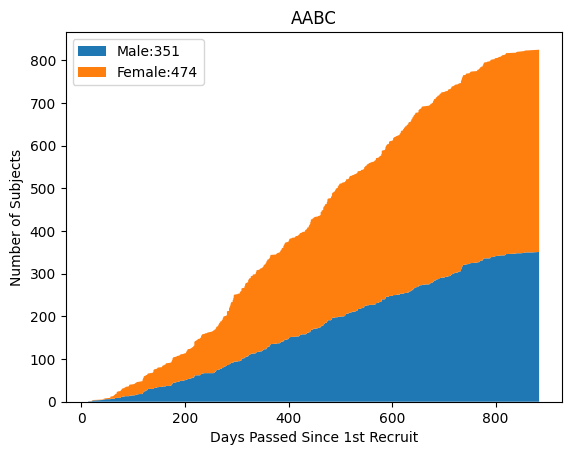

In [384]:
### create plot of AABC recruitment stats by SEX
# Create data
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.malesum) #[1,4,6,8,9]
y2=list(forplot.femalesum)#[2,2,7,10,12]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, labels=['Male:'+str(max(y1)),'Female:'+str(max(y2))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');



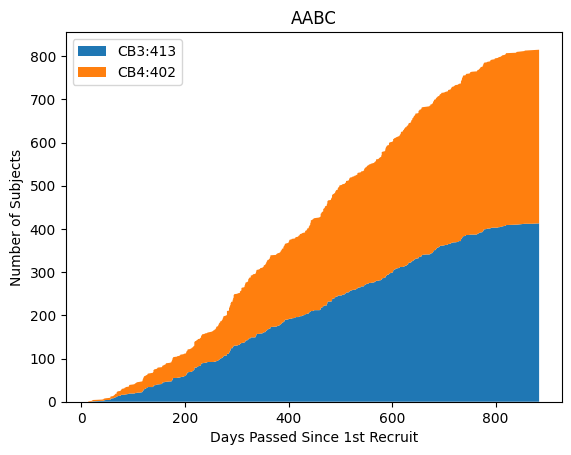

In [385]:
### create plot of AABC recruitment stats by SEX
# Create data
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.CB3sum) #[1,4,6,8,9]
y2=list(forplot.CB4sum)#[2,2,7,10,12]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, labels=['CB3:'+str(max(y1)),'CB4:'+str(max(y2))])
plt.title("AABC")
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

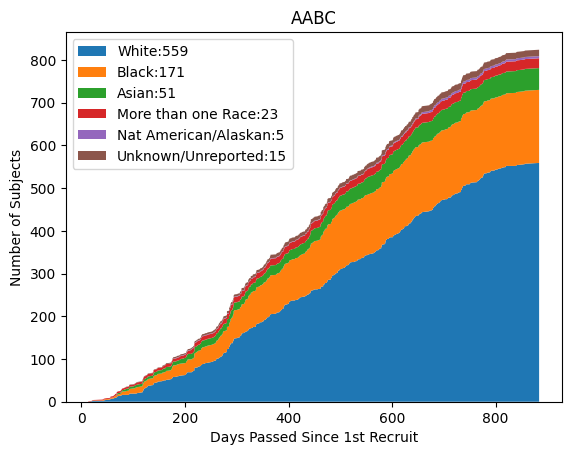

In [386]:
#BY RACE
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.whitesum) #[1,4,6,8,9]
y2=list(forplot.blacksum)#[2,2,7,10,12]
y3=list(forplot.asiansum)
y4=list(forplot.moret1sum)
#y5=list(forplot.natpacsum)
y6=list(forplot['natamersum'])
y7=list(forplot['nasum'])



# Basic stacked area chart.
plt.stackplot(x,y1,y2,y3,y4,y6,y7,labels=['White:'+str(max(y1)),'Black:'+str(max(y2)),'Asian:'+str(max(y3)),'More than one Race:'+str(max(y4)),'Nat American/Alaskan:'+str(max(y6)),'Unknown/Unreported:'+str(max(y7))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

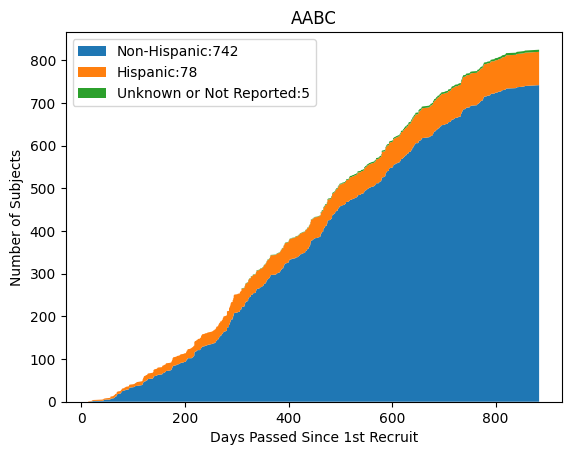

In [387]:
#BY ETHNICITY
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.nonhispanicsum) #[1,4,6,8,9]
y2=list(forplot.hispanicsum)#[2,2,7,10,12]
y3=list(forplot.unkhispsum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3, labels=['Non-Hispanic:'+str(max(y1)),'Hispanic:'+str(max(y2)),'Unknown or Not Reported:'+str(max(y3))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

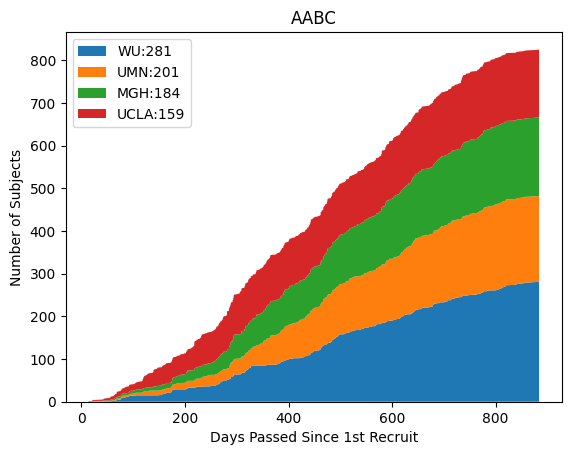

In [388]:
#By Site
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.wusum) #[1,4,6,8,9]
y2=list(forplot.umnsum)#[2,2,7,10,12]
y3=list(forplot.mghsum)
y4=list(forplot.uclasum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3, y4,labels=['WU:'+str(max(y1)),'UMN:'+str(max(y2)),'MGH:'+str(max(y3)),'UCLA:'+str(max(y4))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');


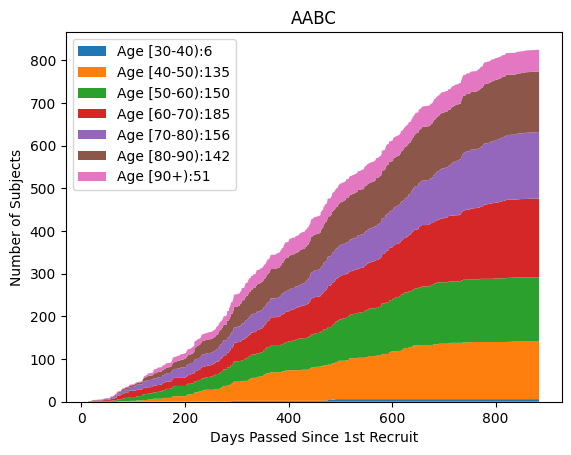

In [389]:
#By Age Bin
x=list(forplot.dayspassed) #range(1,6)
y2=list(forplot.age30sum)#[2,2,7,10,12]
y3=list(forplot.age40sum)
y4=list(forplot.age50sum)
y5=list(forplot.age60sum)
y6=list(forplot.age70sum)
y7=list(forplot.age80sum)
y8=list(forplot.age90sum)

# Basic stacked area chart.
plt.stackplot(x,y2,y3,y4,y5,y6,y7,y8, labels=['Age [30-40):'+str(max(y2)),'Age [40-50):'+str(max(y3)),'Age [50-60):'+str(max(y4)),'Age [60-70):'+str(max(y5)),'Age [70-80):'+str(max(y6)),'Age [80-90):'+str(max(y7)),'Age [90+):'+str(max(y8))])
plt.legend(loc='upper left')
plt.title("AABC")
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects');

### AABC Crosstabulations


Site,MGH,UCLA,UMN,WashU
Race,,,,
Asian,12,25,12,2
Black,27,19,20,105
More than one,4,15,2,2
Nat Amer/Alaskan,0,1,1,3
Nat Hawaiian/PI,0,1,0,0
Unknown,5,5,5,0
White,136,93,161,169


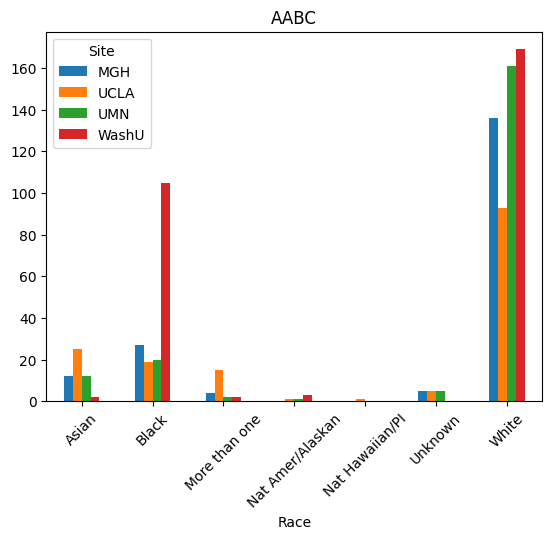

In [390]:
#Crosstabs x Site

pd.crosstab(forplot.Race,forplot.Site).plot.bar(rot=45,title='AABC')
#pd.crosstab(forplot.Race,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Site)

Site,MGH,UCLA,UMN,WashU
Ethnicity,,,,
Hispanic,17,48,9,4
Non-Hispanic,165,110,190,277
Unknown,2,1,2,0


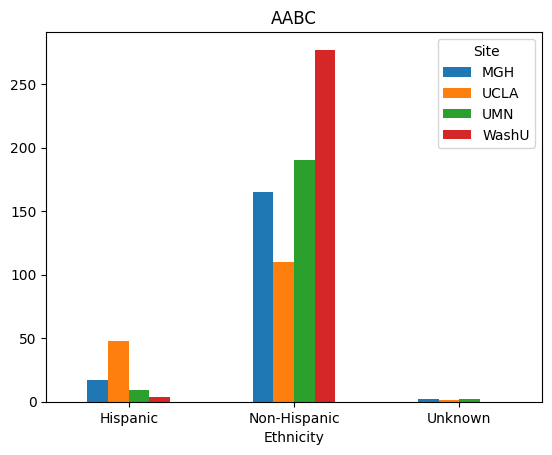

In [391]:
pd.crosstab(forplot.Ethnicity,forplot.Site).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Ethnicity,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Ethnicity,forplot.Site)

Site,MGH,UCLA,UMN,WashU
AgeGroup,,,,
"[30, 40)",0,0,0,6
"[40, 50)",24,27,35,49
"[50, 60)",35,35,33,47
"[60, 70)",41,34,40,70
"[70, 80)",30,23,42,61
"[80, 90)",37,29,38,38
"[90, 125)",17,11,13,10


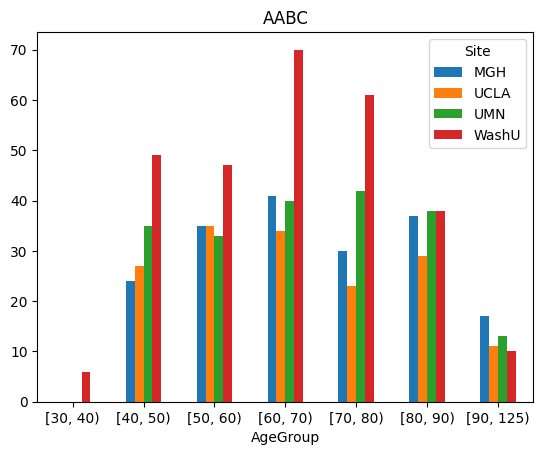

In [392]:
pd.crosstab(forplot.AgeGroup,forplot.Site).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Site)

Site,MGH,UCLA,UMN,WashU
Sex,,,,
Female,104,89,112,169
Male,80,70,89,112


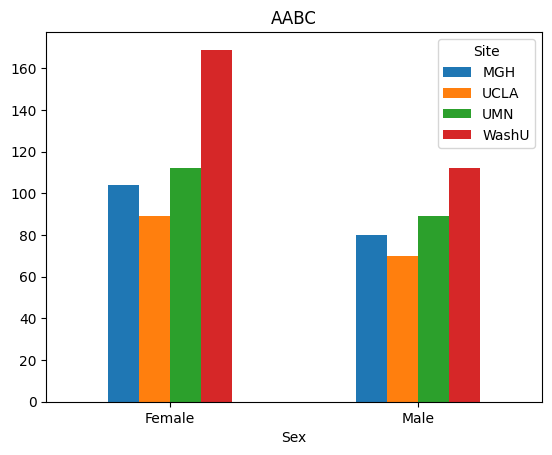

In [393]:
pd.crosstab(forplot.Sex,forplot.Site).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Sex,forplot.Site).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Sex,forplot.Site)

Race,Asian,Black,More than one,Nat Amer/Alaskan,Nat Hawaiian/PI,Unknown,White
AgeGroup,,,,,,,
"[30, 40)",0,4,0,0,0,0,2
"[40, 50)",12,33,6,1,0,5,78
"[50, 60)",12,39,6,3,1,4,85
"[60, 70)",15,45,7,1,0,6,111
"[70, 80)",7,33,2,0,0,0,114
"[80, 90)",5,15,1,0,0,0,121
"[90, 125)",0,2,1,0,0,0,48


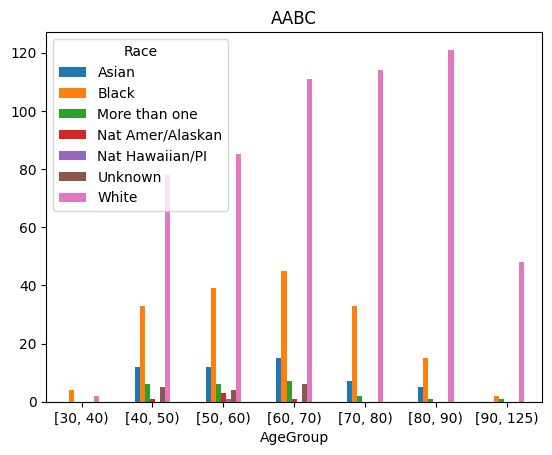

In [394]:
pd.crosstab(forplot.AgeGroup,forplot.Race).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Race).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Race)

Ethnicity,Hispanic,Non-Hispanic,Unknown
AgeGroup,,,
"[30, 40)",0,6,0
"[40, 50)",22,112,1
"[50, 60)",23,125,2
"[60, 70)",17,167,1
"[70, 80)",7,149,0
"[80, 90)",6,135,1
"[90, 125)",3,48,0


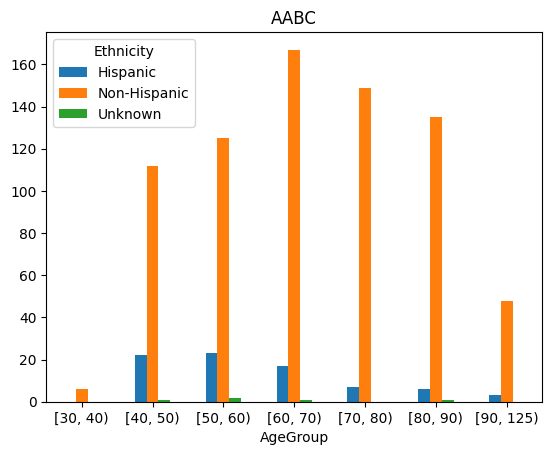

In [395]:
pd.crosstab(forplot.AgeGroup,forplot.Ethnicity).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Ethnicity).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Ethnicity)


Sex,Female,Male
AgeGroup,,
"[30, 40)",3,3
"[40, 50)",80,55
"[50, 60)",93,57
"[60, 70)",115,70
"[70, 80)",82,74
"[80, 90)",74,68
"[90, 125)",27,24


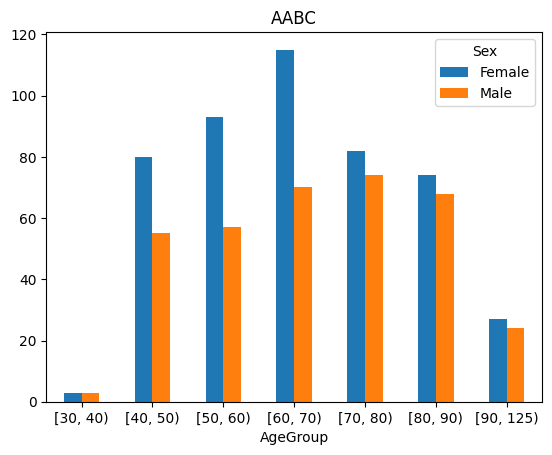

In [396]:
pd.crosstab(forplot.AgeGroup,forplot.Sex).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Sex)

Sex,Female,Male
Race,,
Asian,25,26
Black,116,55
More than one,12,11
Nat Amer/Alaskan,2,3
Nat Hawaiian/PI,0,1
Unknown,9,6
White,310,249


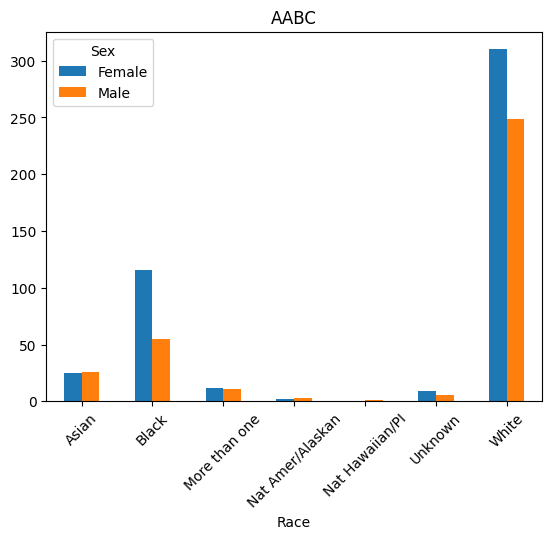

In [397]:
#Crosstabs
pd.crosstab(forplot.Race,forplot.Sex).plot.bar(rot=45,title='AABC')
#pd.crosstab(forplot.Race,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Sex)

Sex,Female,Male
Ethnicity,,
Hispanic,45,33
Non-Hispanic,426,316
Unknown,3,2


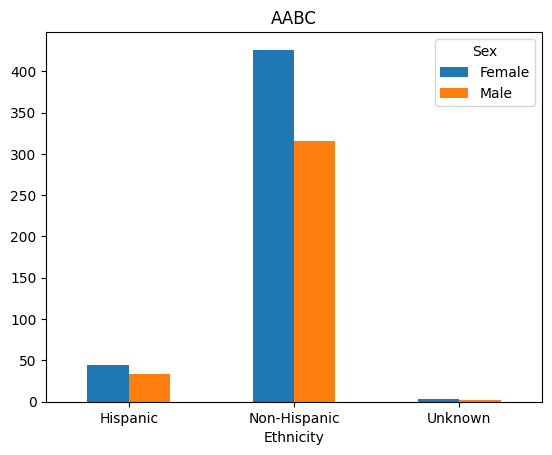

In [398]:
#Crosstabs
pd.crosstab(forplot.Ethnicity,forplot.Sex).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Ethnicity,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Ethnicity,forplot.Sex)

Sex,Female,Male
Counterbalance,,
,4,6
CB3,241,172
CB4,229,173


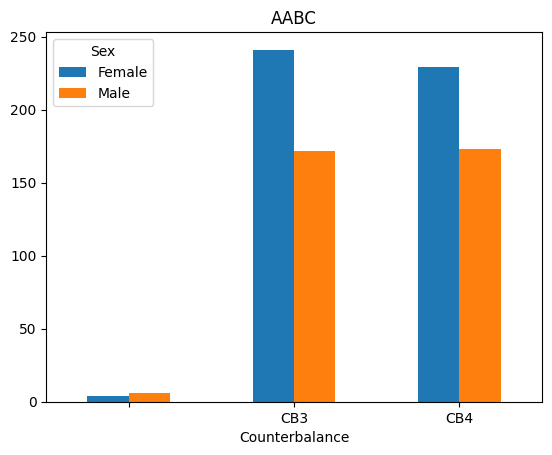

In [399]:
#Crosstabs
pd.crosstab(forplot.Counterbalance,forplot.Sex).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.Counterbalance,forplot.Sex).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Counterbalance,forplot.Sex)

Counterbalance,,CB3,CB4
Race,,,
Asian,0,24,27
Black,2,84,85
More than one,0,15,8
Nat Amer/Alaskan,0,3,2
Nat Hawaiian/PI,0,1,0
Unknown,1,8,6
White,7,278,274


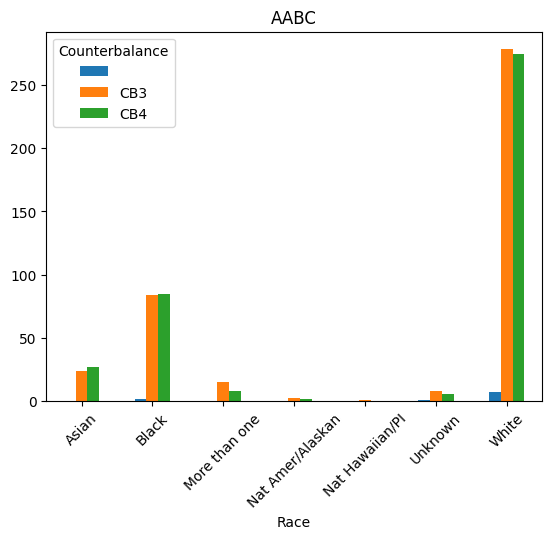

In [400]:
#Crosstabs
pd.crosstab(forplot.Race,forplot.Counterbalance).plot.bar(rot=45,title='AABC')
#pd.crosstab(forplot.Race,forplot.Counterbalance).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.Race,forplot.Counterbalance)

Counterbalance,,CB3,CB4
AgeGroup,,,
"[30, 40)",0,3,3
"[40, 50)",2,70,63
"[50, 60)",1,82,67
"[60, 70)",2,84,99
"[70, 80)",2,79,75
"[80, 90)",3,70,69
"[90, 125)",0,25,26


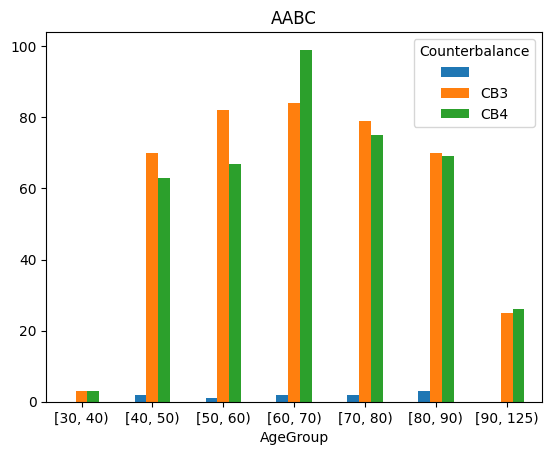

In [401]:
#Crosstabs
pd.crosstab(forplot.AgeGroup,forplot.Counterbalance).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Counterbalance).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.AgeGroup,forplot.Counterbalance)

### New crosstabs plots including income and education group

Race,Asian,Black,More than one,Nat Amer/Alaskan,Nat Hawaiian/PI,Unknown,White
IncomeGroup,,,,,,,
0-20k,2,17,0,0,0,2,14
20k-50k,3,50,5,1,0,1,92
50k-100k,13,70,12,1,1,8,196
100k+,30,21,5,2,0,3,207
Don't know,3,13,1,1,0,1,50


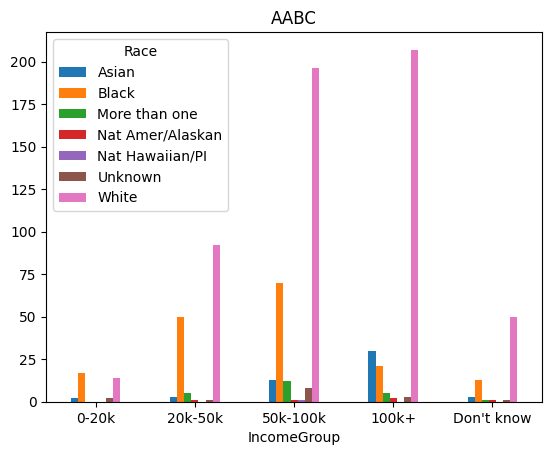

In [402]:
#Crosstabs
pd.crosstab(forplot.IncomeGroup,forplot.Race).plot.bar(rot=0,title='AABC')
#pd.crosstab(forplot.AgeGroup,forplot.Counterbalance).to_csv('Recruitment_Stats',mode='a')
pd.crosstab(forplot.IncomeGroup,forplot.Race)

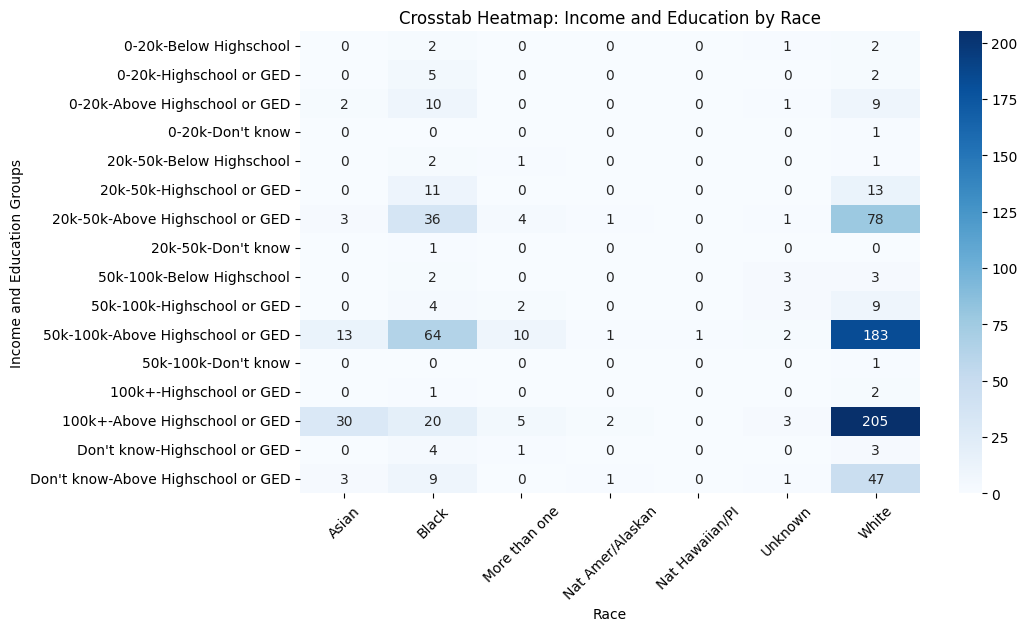

In [403]:
crosstab_result = pd.crosstab([forplot['Race']], [forplot['IncomeGroup'], forplot['EduGroup']], margins=True)
crosstab_reset = crosstab_result.reset_index()

# Using a heatmap to visualize
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_result.iloc[:-1, :-1].T, annot=True, cmap='Blues', fmt='g')

# Customize plot
plt.xticks(rotation=45)
plt.title('Crosstab Heatmap: Income and Education by Race')
plt.ylabel('Income and Education Groups')
plt.xlabel('Race')

plt.show()